In [1]:
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import Input, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import random as rn
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

import sounddevice as sd

from memory_profiler import memory_usage
import pandas as pd
import tensorflow as tf
from glob import glob

import librosa
import librosa.display
import pylab

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import IPython.display as ipd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
import sklearn
import soundfile as sf
import gc

%matplotlib inline
sns.set(style='whitegrid', color_codes=True)

import sys
from PIL import Image
sys.modules['Image'] = Image 

seed = 100
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

In [2]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = './spectogram/train/' + name + '.png'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [3]:
def create_spectrogram_test(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('./spectogram/test/' + name + '.png')
    fig.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [4]:
labels = pd.read_csv('train_labels.csv')
sample_solution = pd.read_csv('sample_submission.csv')
train = np.load('train_data.npy')
test = np.load('test_data.npy')

In [5]:
print(train.shape)
print(test.shape)
print(labels.shape)

(3999, 44100)
(3997, 44100)
(3999, 2)


In [6]:
# sampling frequency
fs = 44100
#sd.play(train[6], fs)
#sd.play(test[34], fs)

In [7]:
#  Generate out the .wav files for creating the spectograms

# def create_wav_file(filename, data):
#     sf.write(filename, data, 44100)

# test_size=3997
# train_size=3999

# for i in range(0,test_size):
#     create_wav_file('./audio/test/' + str(i) + '.wav', test[i])
    
# for i in range(0,train_size):
#     create_wav_file('./audio/train/' + str(i) + '.wav', train[i])

In [20]:
# Create spectograms for Train

# %load_ext memory_profiler
# Train_dir=np.array(glob('./audio/train/*.wav'))

# %memit 
# i=0
# for file in Train_dir[i:i+2000]:
#     filename,name = file,file.split('/')[-1].split('.')[0]
#     create_spectrogram(filename,name)
# gc.collect()
# %memit 
# i=2000
# for file in Train_dir[i:]:
#     filename,name = file,file.split('/')[-1].split('.')[0]
#     create_spectrogram(filename,name)
# gc.collect()

peak memory: 5324.68 MiB, increment: 0.16 MiB
peak memory: 5341.57 MiB, increment: 0.00 MiB


47425

In [21]:
# Create spectograms for Test

# Test_dir=np.array(glob('./audio/test/*.wav'))
# %memit 
# i=0
# for file in Test_dir[i:i+2000]:
#     filename,name = file,file.split('/')[-1].split('.')[0]
#     create_spectrogram_test(filename,name)
# gc.collect()
# %memit 
# i=2000
# for file in Test_dir[i:]:
#     filename,name = file,file.split('/')[-1].split('.')[0]
#     create_spectrogram_test(filename,name)
# gc.collect()

peak memory: 5342.45 MiB, increment: 0.00 MiB
peak memory: 5368.20 MiB, increment: 0.00 MiB


44031

In [56]:
# train: we see 3999 records of data with sampling frequency of 44100
# test: we see 3997 records of data with sampling frequency of 44100
def append_ext(fn):
    return fn+".png"

train_labels = pd.read_csv('train_labels.csv', dtype=str)
test_labels = pd.read_csv('sample_submission.csv', dtype=str)

train_labels["Id"]=train_labels["Id"].apply(append_ext)
test_labels["Id"]=test_labels["Id"].apply(append_ext)

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory="./spectogram/train/",
    x_col="Id",
    y_col="Label",
    subset="training",
    batch_size=43,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))

valid_generator=datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory="./spectogram/train/",
    x_col="Id",
    y_col="Label",
    subset="validation",
    batch_size=43,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(64,64))


Found 3000 validated image filenames belonging to 2 classes.
Found 999 validated image filenames belonging to 2 classes.


In [79]:
# create convolution neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(Adam(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_83 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
activation_84 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 31, 31, 64)      

In [80]:
#Fitting keras model, no test gen for now
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=150
)
model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID
)

Epoch 1/150
428/428 [==============================] - 7s 16ms/step - loss: 0.2516 - acc: 0.8927 - val_loss: 0.2395 - val_acc: 0.9175
Epoch 2/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1767 - acc: 0.9318 - val_loss: 0.2088 - val_acc: 0.9165
Epoch 3/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1647 - acc: 0.9362 - val_loss: 0.1850 - val_acc: 0.9326
Epoch 4/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1344 - acc: 0.9469 - val_loss: 0.1230 - val_acc: 0.9567
Epoch 5/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1209 - acc: 0.9546 - val_loss: 0.1130 - val_acc: 0.9557
Epoch 6/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1133 - acc: 0.9572 - val_loss: 0.1176 - val_acc: 0.9517
Epoch 7/150
428/428 [==============================] - 6s 13ms/step - loss: 0.1087 - acc: 0.9586 - val_loss: 0.1124 - val_acc: 0.9618
Epoch 8/150
428/428 [==============================] - 6s 13ms

Epoch 62/150
428/428 [==============================] - 6s 13ms/step - loss: 0.0212 - acc: 0.9950 - val_loss: 0.1959 - val_acc: 0.9769
Epoch 63/150
428/428 [==============================] - 6s 13ms/step - loss: 0.0239 - acc: 0.9933 - val_loss: 0.1532 - val_acc: 0.9789
Epoch 64/150
428/428 [==============================] - 6s 13ms/step - loss: 0.0407 - acc: 0.9893 - val_loss: 0.1438 - val_acc: 0.9678
Epoch 65/150
428/428 [==============================] - 6s 14ms/step - loss: 0.0154 - acc: 0.9937 - val_loss: 0.1861 - val_acc: 0.9769
Epoch 66/150
428/428 [==============================] - 6s 14ms/step - loss: 0.0196 - acc: 0.9957 - val_loss: 0.1407 - val_acc: 0.9799
Epoch 67/150
428/428 [==============================] - 6s 13ms/step - loss: 0.0209 - acc: 0.9960 - val_loss: 0.1273 - val_acc: 0.9738
Epoch 68/150
428/428 [==============================] - 6s 13ms/step - loss: 0.0300 - acc: 0.9926 - val_loss: 0.1279 - val_acc: 0.9728
Epoch 69/150
428/428 [==============================] -

[0.4142943337133561, 0.9768612]

In [90]:
score = model.evaluate_generator(valid_generator, STEP_SIZE_VALID)
print(score)

[0.4142943337133561, 0.9768612]


In [96]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory="./spectogram/test/",
    x_col="Id",
    y_col=None,
    batch_size=7,
    seed=seed,
    shuffle=False,
    class_mode=None,
    target_size=(64,64))

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 3997 validated image filenames.


In [97]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

#Fetch labels from train gen for testing
print(train_generator.class_indices)
print(len(predicted_class_indices))
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
print(len(predictions))

571/571 [==============================] - 5s 9ms/step
{'0': 0, '1': 1}
3997
3997


In [98]:
print(predictions[0:11])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1']


In [76]:
plt.plot(mf.history['loss'])
plt.plot(mf.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['train', 'validation'])
plt.show()

NameError: name 'mf' is not defined

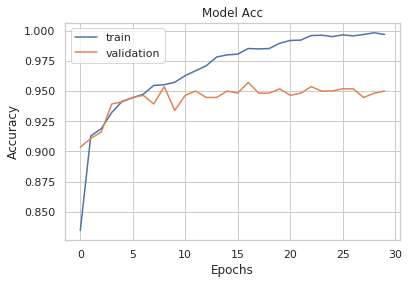

In [164]:
plt.plot(mf.history['acc'])
plt.plot(mf.history['val_acc'])
plt.title('Model Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(['train', 'validation'])
plt.show()

0
3997


In [107]:
print(len(predictions))
print(sample_solution.shape[0])
sample_solution['Label'] = predictions

3997
3997


In [108]:
sample_solution.to_csv('predictions/audio_binary_classification_predict-8.csv', index=False)